In [1]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math
import sklearn.preprocessing

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix

In [4]:
n=25000
r=0.5

In [5]:
x_pos = np.random.normal(loc=0, scale=5*n, size=(int(n*r*0.5)))
x_pos_2 = np.random.normal(loc=40*n, scale=5*n, size=(int(n*r*0.5)))

x_neg= np.random.normal(loc=20*n, scale=5*n, size=(n-int(n*r))//2)
x_neg_2 = np.random.normal(loc=60*n, scale=5*n, size=(n-int(n*r))//2)

x_train = np.concatenate((x_pos,x_neg_2,x_pos_2, x_neg)).reshape(-1, 1).astype(int)

y_train = np.concatenate((np.ones(int(n*r*0.5)), np.zeros((n-int(n*r))//2),np.ones(int(n*r*0.5)),np.zeros((n-int(n*r))//2))).reshape(-1, 1).astype(int)

In [6]:
x_train = StandardScaler().fit_transform(x_train)

In [7]:
x_train.shape

(25000, 1)

In [8]:
y_train.shape

(25000, 1)

<AxesSubplot:ylabel='Count'>

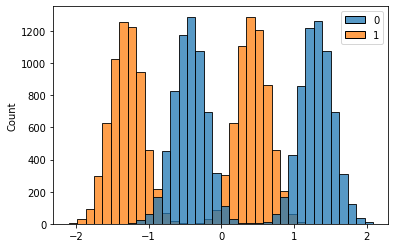

In [9]:
sns.histplot(x=x_train.flatten(), hue=y_train.flatten())

# Model training

In [10]:
additional_metrics = ['acc']
loss_function = BinaryCrossentropy()
number_of_epochs = 10000
optimizer = Adam()
verbosity_mode = 0
layer_size = 5

In [11]:
model = Sequential()
model.add(Dense(layer_size,input_dim=1,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [12]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size = len(x_train)

In [15]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

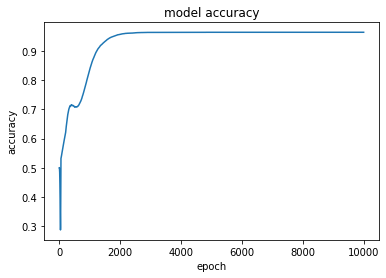

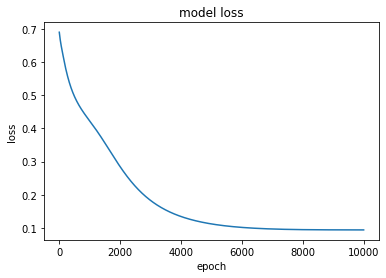

In [16]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#Hidden Layer Size=5

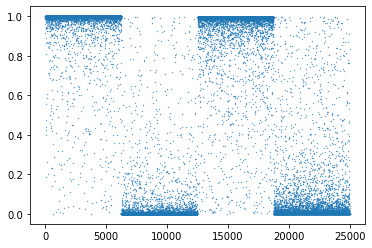

In [17]:
preds =model.predict(x_train)
plt.scatter(np.arange(len(preds)), preds, s=0.1)

In [23]:
layer_size = 10
number_of_epochs = 7000
model = Sequential()
model.add(Dense(layer_size,input_dim=1,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
model.summary()
history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


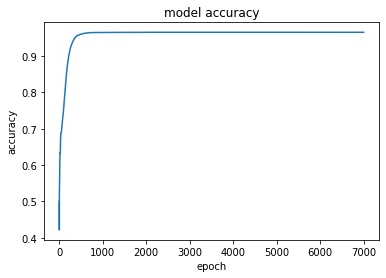

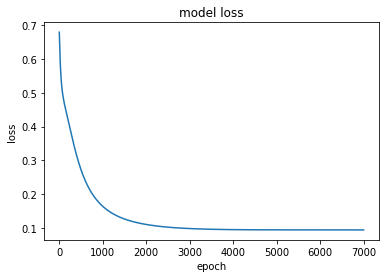

In [24]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#Hidden Layer Size=10

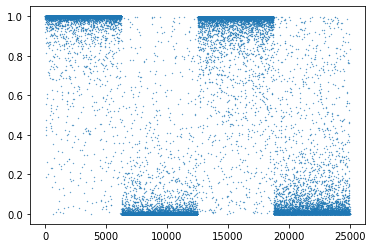

In [25]:
preds =model.predict(x_train)
plt.scatter(np.arange(len(preds)), preds, s=0.1)

# Bloom Filter

In [26]:
class BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1
    
    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(bf.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#(Input:bloom filter,number array,ratio; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x,y):
    pred = bf.predict(x)
    tn, fp, fn, tp = confusion_matrix(y, pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k


def fpr_test(x,bf,y):
    pred=bf.predict(x)
    fp=0
    tn=0
    for i in range(len(pred)):
        if((pred[i]==1)and(y[i]==0)):
            fp+=1
        if((pred[i]==0) and (y[i]==0)):
            tn+=1
        if((pred[i]==0) and (y[i]==1)):
            return -1
    print(fp)
    print(tn)
    return fp/(fp+tn)
#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [27]:
m=75000

In [28]:
bf=BloomFilter(m,model)

In [29]:
bf.add_init(x_train,y_train)

In [30]:
print(fpr_kraska_hash(bf,x_train,y_train))

0.01584
